In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class ReactorsInSeries_:
    def __init__(self, k1, k2, k3, F0, V1, V2, V3):
        self.k1 = k1  # Reaction rate constant for reactor 1
        self.k2 = k2  # Reaction rate constant for reactor 2
        self.k3 = k3  # Reaction rate constant for reactor 3
        self.F0 = F0  # Inlet feed flow rate
        self.V1 = V1  # Volume of reactor 1
        self.V2 = V2  # Volume of reactor 2
        self.V3 = V3  # Volume of reactor 3
        
    def dynamics(self, t, x, u):
        H1, xA1, xB1, T1, H2, xA2, xB2, T2, H3, xA3, xB3, T3 = x
        Q1, Q2, Q3, Ff1, Ff2, FR = u
        
        # Assuming some arbitrary values for enthalpy changes
        delta_H_r1 = -50
        delta_H_r2 = -60
        delta_H_r3 = -70
        
        # Reactor 1
        r1 = self.k1 * (xA1 * xB1)**0.5
        dH1dt = (self.F0 + FR - Ff1 - H1 * Q1) / self.V1
        dxA1dt = (self.F0 * xA1 + FR * 0 - Ff1 * xA1 - H1 * Q1 * xA1 - r1 * self.V1) / (self.V1 * H1)
        dxB1dt = (self.F0 * xB1 + FR * 0 - Ff1 * xB1 - H1 * Q1 * xB1 - r1 * self.V1) / (self.V1 * H1)
        dT1dt = (self.F0 * T1 + FR * 298.15 - Ff1 * T1 - H1 * Q1 * T1 + (-delta_H_r1) * r1 * self.V1) / (self.V1 * H1)
        
        # Reactor 2
        r2 = self.k2 * (xA2 * xB2)**0.5
        dH2dt = (H1 * Q1 - Ff2 - H2 * Q2) / self.V2
        dxA2dt = (H1 * Q1 * xA1 - Ff2 * xA2 - H2 * Q2 * xA2 - r2 * self.V2) / (self.V2 * H2)
        dxB2dt = (H1 * Q1 * xB1 - Ff2 * xB2 - H2 * Q2 * xB2 - r2 * self.V2) / (self.V2 * H2)
        dT2dt = (H1 * Q1 * T1 - Ff2 * T2 - H2 * Q2 * T2 + (-delta_H_r2) * r2 * self.V2) / (self.V2 * H2)
        
        # Reactor 3
        r3 = self.k3 * (xA3 * xB3)**0.5
        dH3dt = (H2 * Q2 - self.F0 - FR - H3 * Q3) / self.V3
        dxA3dt = (H2 * Q2 * xA2 - self.F0 * xA3 - FR * 0 - H3 * Q3 * xA3 - r3 * self.V3) / (self.V3 * H3)
        dxB3dt = (H2 * Q2 * xB2 - self.F0 * xB3 - FR * 0 - H3 * Q3 * xB3 - r3 * self.V3) / (self.V3 * H3)
        dT3dt = (H2 * Q2 * T2 - self.F0 * T3 - FR * 298.15 - H3 * Q3 * T3 + (-delta_H_r3) * r3 * self.V3) / (self.V3 * H3)
        
        return [dH1dt, dxA1dt, dxB1dt, dT1dt, dH2dt, dxA2dt, dxB2dt, dT2dt, dH3dt, dxA3dt, dxB3dt, dT3dt]
    
    def simulate(self, t_span, x0, u):
        sol = solve_ivp(self.dynamics, t_span, x0, args=(u,))
        return sol.t, sol.y
    
    def plot_results(self, t, x):
        fig, axes = plt.subplots(4, 3, figsize=(15, 10))
        state_names = ['H', 'xA', 'xB', 'T']
        reactor_numbers = ['1', '2', '3']

        for i in range(4):  # Iterate over states
            for j in range(3):  # Iterate over reactors
                state_idx = i * 3 + j
                axes[i, j].plot(t, x[state_idx], label=f'Reactor {reactor_numbers[j]}')
                axes[i, j].set_xlabel('Time')
                axes[i, j].set_ylabel(f'{state_names[i]}{reactor_numbers[j]}')
                axes[i, j].legend()

        plt.tight_layout()
        plt.show()

# Example usage
k1 = 0.1
k2 = 0.2
k3 = 0.3
F0 = 10.0
V1 = 100.0
V2 = 150.0
V3 = 200.0

reactor_system = ReactorsInSeries_(k1, k2, k3, F0, V1, V2, V3)

t_span = [0, 30]  # Time span for simulation
x0 = [1.0, 0.5, 0.5, 350.0, 1.0, 0.5, 0.5, 350.0, 1.0, 0.5, 0.5, 350.0]  # Initial conditions for states
u = [1.0, 2.0, 1.5, 0.5, 0.6, 0.8]  # Control inputs

t, x = reactor_system.simulate(t_span, x0, u)
# reactor_system.plot_results(t, x)
# reference = np.copy(x)
reference = []
for i in range(x.shape[0]):
    reference.append(np.interp(np.linspace(0,t[-1], 200), t, np.copy(x[i])))
reference = np.array(reference)


In [2]:
import matplotlib.pyplot as plt

In [3]:
import random
from collections import deque

# Define the memory buffer to store experience tuples
class ReplayBuffer():
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        sampled_experiences = zip(*random.sample(self.buffer, batch_size))
        return sampled_experiences

    def __len__(self):
        return len(self.buffer)

In [4]:
import numpy as np
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from control import Linear_MPC_Controller, ReactorsInSeries
# Example usage
k1 = 0.1
k2 = 0.2
k3 = 0.3
F0 = 10.0
V1 = 100.0
V2 = 150.0
V3 = 200.0

reactor_system = ReactorsInSeries(k1, k2, k3, F0, V1, V2, V3)

t_span = [0, 100]  # Time span for simulation
x0 = [1.0, 0.5, 0.5, 350.0, 1.0, 0.5, 0.5, 350.0, 1.0, 0.5, 0.5, 350.0]  # Initial conditions for states
u = [1.0, 2.0, 1.5, 0.5, 0.6, 0.8]  # Control inputs

# t, x = reactor_system.simulate(t_span, x0, u)
# reactor_system.plot_results(t, x)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cuda:0'
class MLP_network(nn.Module):
    def __init__(self, in_dim, hidem_dims = [32], out_dim = 1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidem_dims[0]).to(torch.float64).to(device)
        self.fc2 = nn.Linear(hidem_dims[0], hidem_dims[1]).to(torch.float64).to(device)
        self.fc3 = nn.Linear(hidem_dims[1], out_dim).to(torch.float64).to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = MLP_network(12+6, [16, 8], 12).to(torch.float64).to(device)
optimizer = optim.Adam(params=mlp.parameters(), lr=0.001)

In [ ]:
# System parameters 
M = 1 #kg
g = 9.81 
L = 1 #m
I = 0.5
J = 0.008
k = 0.3

In [ ]:
# Define system ODE: dx/dt = f(x,u)
#x = [q1, q2, q1_dot, q2_dot]
import numpy as np

def sys_ode(x,u):

    dx_1 = x[0][2] 
    dx_2 = x[0][3]
    dx_3 = -M*g*L*np.sin(x[0][0])/I - k/I * (x[0][0]-x[0][1])
    dx_4 = -k/J * (x[0][1]-x[0][0]) + 1/J * u 
    dx = np.array([dx_1, dx_2, dx_3, dx_4[0,0]]).reshape([1,-1])
    
    return dx

In [ ]:
class Single_Link_Flexible_Joint:
    def __init__(self, dt = 0.001):
        self.Ac = -20*np.eye(4)
        self.dt = dt
        self.t = np.linspace(0, 10, int((10-0)/dt))
        self.xd = np.array([[.2*np.sin(4*np.pi*self.t/3)], [np.sin(4*np.pi*(self.t)/3)], [np.sin(4*np.pi*self.t/3)], [2*np.cos(4*np.pi*(self.t)/3)]]).T
        self.x = np.array([[.1],[.2],[.3],[.4]]).T
    def step(self, u):
        self.x_dot = sys_ode(self.x, u)
        self.x += self.x_dot * self.dt

In [6]:

controller = Linear_MPC_Controller()
plant = Single_Link_Flexible_Joint()


In [7]:
import time
MPC_HORIZON = 10
buffer = ReplayBuffer(1000)
batch_size_max = 32
history = {'loss':[], 'u':[]}
controller.flag = 1
u = np.array([1.0, 2.0, 1.5, 0.5, 0.6, 0.8]).reshape([1,-1])
old_state = plant.x
repeat_num = 1#200
for i in range(reference.shape[1] - MPC_HORIZON):
    # t1=time.time()
    state_hat = mlp.forward(torch.tensor(np.concatenate((old_state, u.reshape([1,-1])), 1)).to(torch.float64).to(device)).detach().cpu().numpy()
    
    old_state = plant.x
    ##
    u = controller.optimize(state_hat, reference[:, i:i+MPC_HORIZON].T)
    history['u'].append(u)
    # plant.dynamics(u)
    plant.step(u)

    #### Observer start
    new_state = plant.x
    history['loss'].append(np.mean((state_hat-new_state)**2))
    
    # if controller.history['loss'][-1] < 5:
    #     i += 1
    if len(buffer) > 1:#batch_size:
        batch_size = min(len(buffer), batch_size_max)
        for i in range(repeat_num):
            a, b = buffer.sample(batch_size)
            a = torch.tensor(np.stack(a).squeeze(1)).to(torch.float64).to(device)
            b = torch.tensor(np.stack(b).squeeze(1)).to(torch.float64).to(device)
            output = mlp(a)
            loss = F.mse_loss(output, b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['loss'].append(loss.detach().cpu().numpy().reshape([1])[0])
            if history['loss'][-1]<0.01:
                repeat_num = 1
    new_state = plant.x
    buffer.push([np.concatenate((old_state, u), 1), new_state])

d:\Master\CMVS\CI\MPC_RNN\Again\Code\control.py:152: RuntimeWarning: invalid value encountered in scalar power
  r2 = self.k2 * (xA2 * xB2)**0.5
d:\Master\CMVS\CI\MPC_RNN\Again\Code\control.py:159: RuntimeWarning: invalid value encountered in scalar power
  r3 = self.k3 * (xA3 * xB3)**0.5
d:\Master\CMVS\CI\MPC_RNN\Again\Code\control.py:145: RuntimeWarning: invalid value encountered in scalar power
  r1 = self.k1 * (xA1 * xB1)**0.5


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [8]:
u

array([[0.001, 0.001, 0.001, 0.001, 0.001, 0.001]])

### Loss history of Observer

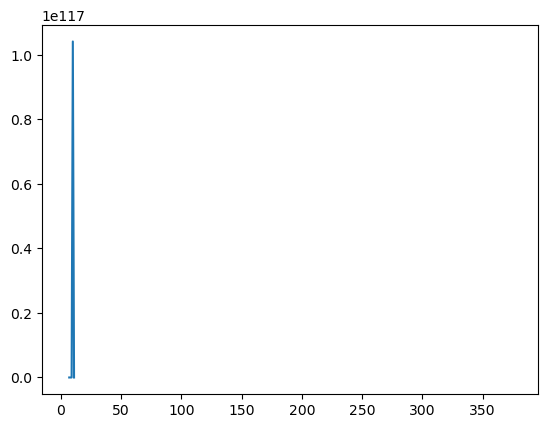

In [9]:
plt.plot(history['loss'])

### Loss history of Recurrent NN

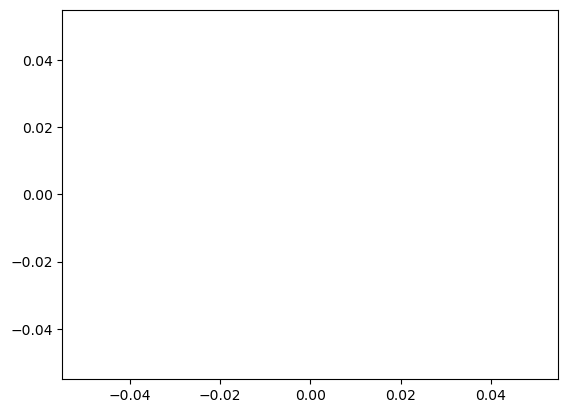

In [10]:
plt.plot(controller.history['loss'])

In [14]:
history['u'] = np.array(history['u'])[:,0,:].T

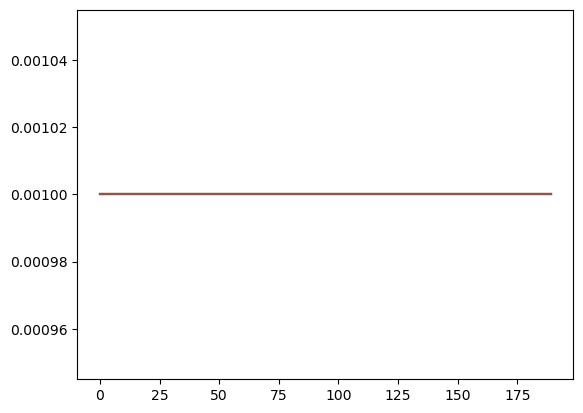

In [16]:
plt.plot(history['u'].T)